# Import packages and Simulation class

In [1]:
## Allows for figure rendering in notebook
%matplotlib inline
'''
Simulation class for Chapter 7 Tutorial of Intro Network Science book

Copyright 2018 Indiana University and Cambridge University Press
'''

from collections import Counter
from operator import itemgetter
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
import math
import seaborn as sns
import pandas as pd
import math
from itertools import combinations

class StopCondition(StopIteration):
    pass

class Simulation:
    '''Simulate state transitions on a network'''

    def __init__(self, G, initial_state, state_transition,
            stop_condition=None, name=''):
        '''
        Create a Simulation instance.

        Args:
            G: a networkx.Graph instance.
            initial_state: function with signature `initial_state(G)`, that
                accepts a single argument, the Graph, and returns a dictionary
                of all node states. The keys in this dict should be node names
                and the values the corresponding initial node state.
            state_transition: function with signature
                `state_transition(G, current_state)` that accepts two
                arguments, the Graph and a dictionary of current node states,
                and returns a dictionary of updated node states. The keys in
                this dict should be node names and the values the corresponding
                updated node state.
            stop_condition (optional): function with signature
                `stop_condition(G, current_state)` that accepts two arguments,
                the Graph and a dictionary of current node states, and returns
                True if the simulation should be stopped at its current state.

        Keyword Args:
            name (optional): a string used in titles of plots and drawings.

        Raises:
            ValueError: if not all graph nodes have an initial state.
        '''
        self.G = G.copy()
        self._initial_state = initial_state
        self._state_transition = state_transition
        self._stop_condition = stop_condition
        # It's okay to specify stop_condition=False
        if stop_condition and not callable(stop_condition):
            raise TypeError("'stop_condition' should be a function")
        self.name = name or 'Simulation'

        self._states = []
        self._value_index = {}
        self._cmap = plt.cm.get_cmap('tab10')

        self._initialize()

        self._pos = nx.layout.spring_layout(G)

    def _append_state(self, state):
        self._states.append(state)
        # Update self._value_index
        for value in set(state.values()):
            if value not in self._value_index:
                self._value_index[value] = len(self._value_index)

    def _initialize(self):
        if self._initial_state:
            if callable(self._initial_state):
                state = self._initial_state(self.G)
            else:
                state = self._initial_state
            nx.set_node_attributes(self.G, state, 'state')

        if any(self.G.nodes[n].get('state') is None for n in self.G.nodes):
            raise ValueError('All nodes must have an initial state')

        self._append_state(state)

    def _step(self):
        # We're choosing to use the node attributes as the source of truth.
        # This allows the user to manually perturb the network in between steps.
        state = nx.get_node_attributes(self.G, 'state')
        if self._stop_condition and self._stop_condition(self.G, state):
            raise StopCondition
        #state = nx.get_node_attributes(self.G, 'state')
        new_state = self._state_transition(self.G, state)
        #state.update(new_state)
        state = new_state
        nx.set_node_attributes(self.G, state, 'state')
        self._append_state(state)

    def _categorical_color(self, value):
        index = self._value_index[value]
        node_color = self._cmap(index)
        return node_color

    @property
    def steps(self):
        ''' Returns the number of steps the sumulation has run '''
        return len(self._states) - 1

    def state(self, step=-1):
        '''
        Get a state of the simulation; by default returns the current state.

        Args:
            step: the step of the simulation to return. Default is -1, the
            current state.

        Returns:
            Dictionary of node states.

        Raises:
            IndexError: if `step` argument is greater than the number of steps.
        '''
        try:
            return self._states[step]
        except IndexError:
            raise IndexError('Simulation step %i out of range' % step)
    
    def props(self,num):
      return self.G.nodes[num]
    
    def graph(self):
      return self.G
    
    def num_nodes(self):
      return self.G.number_of_nodes()

    def draw(self, step=-1, labels=None, **kwargs):
        '''
        Use networkx.draw to draw a simulation state with nodes colored by
        their state value. By default, draws the current state.

        Args:
            step: the step of the simulation to draw. Default is -1, the
            current state.
            kwargs: keyword arguments are passed to networkx.draw()

        Raises:
            IndexError: if `step` argument is greater than the number of steps.
        '''
        state = self.state(step)
        node_colors = [self._categorical_color(state[n]) for n in self.G.nodes]
        nx.draw(self.G, pos=self._pos, node_color=node_colors, **kwargs)

        if labels is None:
            labels = sorted(set(state.values()), key=self._value_index.get)
        patches = [mpl.patches.Patch(color=self._categorical_color(l), label=l)
                   for l in labels]
        plt.legend(handles=patches)

        if step == -1:
            step = self.steps
        if step == 0:
            title = 'initial state'
        else:
            title = 'step %i' % (step)
        if self.name:
            title = '{}: {}'.format(self.name, title)
        plt.title(title)

    def plot(self, min_step=None, max_step=None, labels=None, **kwargs):
        '''
        Use pyplot to plot the relative number of nodes with each state at each
        simulation step. By default, plots all simulation steps.

        Args:
            min_step: the first step of the simulation to draw. Default is
                None, which plots starting from the initial state.
            max_step: the last step, not inclusive, of the simulation to draw.
                Default is None, which plots up to the current step.
            labels: ordered sequence of state values to plot. Default is all
                observed state values, approximately ordered by appearance.
            kwargs: keyword arguments are passed along to plt.plot()

        Returns:
            Axes object for the current plot
        '''
        x_range = range(min_step or 0, max_step or len(self._states))
        counts = [Counter(s.values()) for s in self._states[min_step:max_step]]
        if labels is None:
            labels = {k for count in counts for k in count}
            labels = sorted(labels, key=self._value_index.get)

        for label in labels:
            series = [count.get(label, 0) / sum(count.values()) for count in counts]
            plt.plot(x_range, series, label=label, **kwargs)

        title = 'node state proportions'
        if self.name:
            title = '{}: {}'.format(self.name, title)
        plt.title(title)
        plt.xlabel('Simulation step')
        plt.ylabel('Proportion of nodes')
        plt.legend()
        plt.xlim(x_range.start)

        return plt.gca()

    def run(self, steps=1):
        '''
        Run the simulation one or more steps, as specified by the `steps`
        argument. Default is to run a single step.

        Args:
            steps: number of steps to advance the simulation.
        '''
        for _ in range(steps):
            try:
                self._step()
            except StopCondition as e:
                print(
                    "Stop condition met at step %i." % self.steps
                    )
                break


# Transmitter Receiver: Hydrogen Peroxide Bulk Addition

## Generate initial network

In [2]:
#n=total nodes-1, m= total edges-1, s=initial substrate, h=initial peroxide added
def trans_bulk_net(n,m,s,h):
  # random.seed(100) set seed for reproducibility

  # Add nodes to networkX graph object
  G = nx.gnm_random_graph(n,m)

  # Assign node weights to zero, except initial peroxide conc
  for x in G.nodes():
    nx.set_node_attributes(G, {x:{'s':s, 'QS':0, 'GFP':random.gauss(500,250), 'h2o2':h}})

  return G

## Initial state

In [3]:
def initial_state_trans_bulk(G):
  
    # Initialize the state property
    state = {}
    for g in G.nodes():
        state[g] = 'L1'

    tot = G.number_of_nodes()
    tnodes = random.sample(G.nodes, round(tot*0.1))
    for node in tnodes:
        state[node] = 'Transmitter'


    return state

## Transistion state

In [4]:
def trans_trans_bulk(G, current_state):
    next_state = {}
    
    #Transmitters make AI-1 above h2o2 thresh
    trans_active = [x for x in G.nodes if current_state[x] == 'Transmitter' and random.uniform(0,1) < 1/(1+np.exp(-.5*(G.nodes[x]['h2o2']-8))) and G.nodes[x]['h2o2'] > 0]
    for node in trans_active:
        G.nodes[node]['QS'] += 2*G.nodes[node]['s']/(1+np.exp(-(G.nodes[node]['h2o2'])))
        G.nodes[node]['GFP'] += 2*G.nodes[node]['s']/(1+np.exp(-(G.nodes[node]['h2o2'])))
    #Receivers make GFP based on AI-1
    receiver_active = [x for x in G.nodes if current_state[x] == 'L1' and random.uniform(0,1) < (1/(1+np.exp(-(50*(G.nodes[x]['QS']-.15))))) and G.nodes[x]['QS'] > 0]
    for node in receiver_active:
        #G.nodes[node]['GFP'] += 10*G.nodes[node]['s']/(1+math.exp(-.1*(G.nodes[node]['QS']-3)))
        G.nodes[node]['GFP'] += (G.nodes[node]['QS']*G.nodes[node]['s'])/4 
    
    J = G.copy()
    for node in list(G.nodes):
      #Diffusion of AI-1 through network
        ci = G.nodes[node]['QS'] #set current concentration of this node
        G.nodes[node]['QS'] = ci + alpha * (\
                                sum(J.nodes[j]['QS'] for j in J.neighbors(node))\
                                -ci * J.degree(node)) *Dt 


   
    #If nodes have more than 1 substrate weight they will grow by adding new node w edges to itself and neighbors
    #Weights are divided by two when this happens
    if trans_trans_bulk.counter > 0:
        prob = gr 
        growing = [x for x in G.nodes if G.nodes[x]['s'] >= 1 and random.uniform(0,1) < prob]
        for g in growing:
            k = len(G.nodes) + 1
            neighbors = list(G.neighbors(g))
            if len(neighbors) <= 10:
                    G.add_edge(g,k)
                    G.add_node(k,s = G.nodes[g]['s']/2, GFP = G.nodes[g]['GFP'], h2o2 = G.nodes[g]['h2o2']/2, QS = G.nodes[g]['QS']/2)
                    G.nodes[g]['s'] , G.nodes[g]['h2o2'], G.nodes[g]['QS'] = G.nodes[g]['s']/2, G.nodes[g]['h2o2']/2, G.nodes[g]['QS']/2
                    for x in neighbors:
                        G.add_edge(k,x)
                    current_state[k] = current_state[g]

            else:
                    d_neighbors = random.sample(neighbors,10)
                    G.add_edge(g,k)    
                    G.add_node(k,s = G.nodes[g]['s']/2, GFP = G.nodes[g]['GFP'], h2o2 = G.nodes[g]['h2o2']/2, QS = G.nodes[g]['QS']/2)
                    G.nodes[g]['s'] , G.nodes[g]['h2o2'], G.nodes[g]['QS'] = G.nodes[g]['s']/2, G.nodes[g]['h2o2']/2,  G.nodes[g]['QS']/2
                    for x in d_neighbors:
                        G.add_edge(k,x)
                    current_state[k] = current_state[g]
                    
    trans_trans_bulk.counter += 1
    
    for node in list(G.nodes):
        next_state[node] = current_state[node]

    return next_state

## Set parameters and run simulation

In [ ]:
##Set simulation weight increments and thresholds
import time

#Storage
trans_bulk = {}
steps = 400
alpha = 1
Dt = 0.01
gr = 0.015 #growth probability

#Test range of charge times, during charge time there's no growth so t_charge=lag_time
h_range = [0, 1.56, 3.13, 6.25, 12.5, 25, 50, 100] #initial h2o2 concentrations to test

for k in range(10):
    start = time.time()
    data = []
    for h in h_range:
        trans_trans_bulk.counter = 0
        G = trans_bulk_net(100, 200, 20, h)
        sim = Simulation(G, initial_state_trans_bulk, trans_trans_bulk)
        for x in range(0, steps, 1):
          sim.run()
          current_state = sim.state()
          for key in current_state:
            data.append([current_state[key], key, h, x, sim.props(key)['h2o2'], sim.props(key)['QS'], sim.props(key)['GFP']])

  #Change lists to DF
    trans_bulk_df = pd.DataFrame(data)
    trans_bulk_df.columns = ['Strain', 'Node', 'Initial H2O2', 'Step', 'H2O2', 'QS', 'GFP']
    trans_bulk_df.to_csv('20230726_trans_bulk_biofilm_' + str(k) +'.csv', index=False)
    print((time.time() - start)/60)

6.015179900328318
6.618283291657765


C:\ProgramData\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


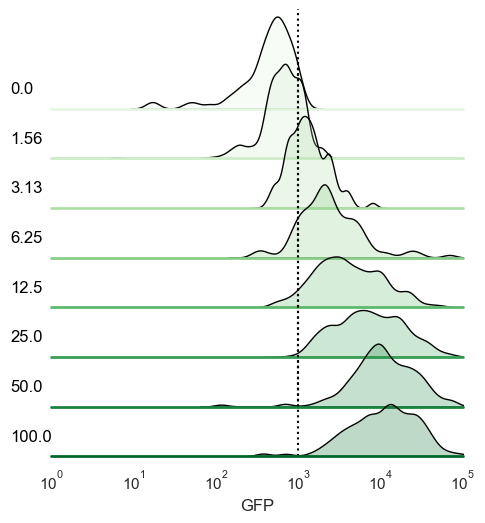

In [9]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data

data = trans_bulk_df
df = data[data['Step']== 360]

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="Initial H2O2", hue="Initial H2O2", aspect=7, height=.7, palette='Greens')

# Draw the densities in a few steps
g.map(sns.kdeplot, "GFP", log_scale=True, edgecolor='black',fill=True)
#g.map(sns.histplot, "GFP", kde=True, edgecolor = 'white', color='black', log_scale=True)
#g.map(sns.histplot, "GFP", alpha = 1, log_scale=True)
g.map(plt.axvline, x=1000, ls=':', c = 'black')

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.1, 0.2, label,  color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "GFP", color='black')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
plt.xlim([1,100000])
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
#plt.title('20220919 mono_bulk', loc = 'right')
#plt.savefig('20230110 mono_bulk', transparent=True, bbox_inches='tight')

C:\Users\Austin\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


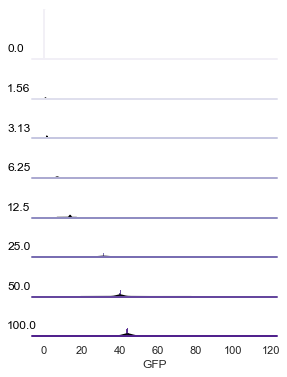

In [116]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data

data = trans_bulk_df[trans_bulk_df['Strain']=='Transmitter']
df = data[data['Step']== 360]

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="Initial H2O2", hue="Initial H2O2", aspect=6, height=.7, palette='Purples')

# Draw the densities in a few steps
g.map(sns.histplot, "QS", kde=True, edgecolor = 'white', color='black')
g.map(sns.histplot, "QS", alpha = 1)
#g.map(plt.axvline, x=1000, ls='--', c = 'black')

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.1, 0.2, label,  color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "GFP", color='black')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
#plt.xlim([1,100000])
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
#plt.title('20220919 mono_bulk', loc = 'right')
#plt.savefig('20230110 mono_bulk', transparent=True, bbox_inches='tight')

<ipython-input-77-573c553b00f1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==0]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==0]['QS'])
<ipython-input-77-573c553b00f1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==0]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==0]['QS'])
<ipython-input-77-573c553b00f1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==0]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['

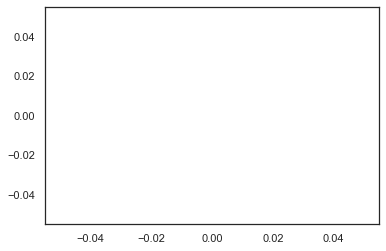

In [77]:
plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==0]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==0]['QS'])

<ipython-input-117-445af1435a5b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==1.56]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==1.56]['QS'])
<ipython-input-117-445af1435a5b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==1.56]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==1.56]['QS'])
<ipython-input-117-445af1435a5b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==1.56]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1

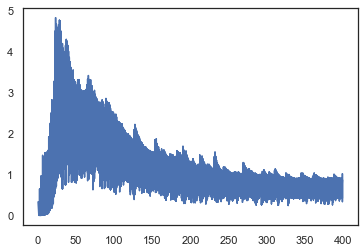

In [117]:
plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==1.56]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==1.56]['QS'])

<ipython-input-118-16eaa9aad9e1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==3.13]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==3.13]['QS'])
<ipython-input-118-16eaa9aad9e1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==3.13]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==3.13]['QS'])
<ipython-input-118-16eaa9aad9e1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==3.13]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1

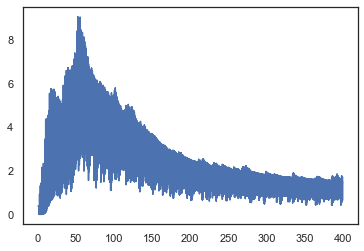

In [118]:
plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==3.13]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==3.13]['QS'])

<ipython-input-119-0bea3edc8473>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==6.25]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==6.25]['QS'])
<ipython-input-119-0bea3edc8473>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==6.25]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==6.25]['QS'])
<ipython-input-119-0bea3edc8473>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==6.25]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1

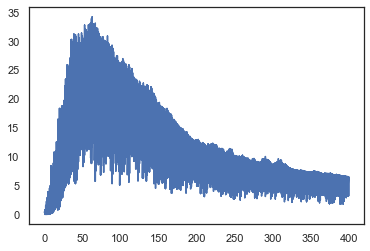

In [119]:
plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==6.25]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==6.25]['QS'])

<ipython-input-120-0b7c5cbe3658>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==12.5]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==12.5]['QS'])
<ipython-input-120-0b7c5cbe3658>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==12.5]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==12.5]['QS'])
<ipython-input-120-0b7c5cbe3658>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==12.5]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1

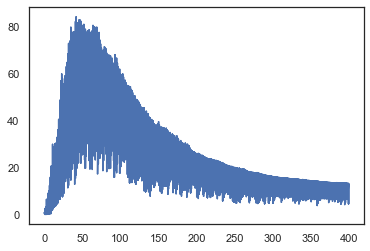

In [120]:
plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==12.5]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==12.5]['QS'])

<ipython-input-121-311b27d020e9>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==25]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==25]['QS'])
<ipython-input-121-311b27d020e9>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==25]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==25]['QS'])
<ipython-input-121-311b27d020e9>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==25]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_b

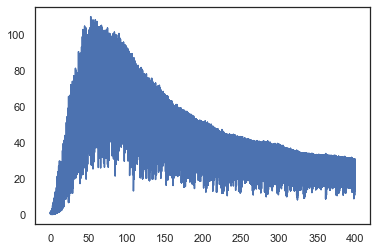

In [121]:
plt.plot(trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==25]['Step'], trans_bulk_df[trans_bulk_df['QS']>0][trans_bulk_df['Strain']=='L1'][trans_bulk_df['Initial H2O2']==25]['QS'])